<a href="https://colab.research.google.com/github/PatienceGutyungwa/Bias-Audit-Report/blob/main/PatienceGutyungwa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset sample:


,gender,years_experience,education_level,seniority,role,location_level,salary,high_pay
0,1,3,0,2,manager,0,60501,0
1,0,2,0,0,engineer,1,63177,0
2,0,4,0,1,manager,2,76452,1
3,1,7,1,2,devops,0,96732,1
4,1,7,0,0,product,2,77749,1



Classification report (before mitigation):
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       600
           1       0.77      0.72      0.74       600

    accuracy                           0.75      1200
   macro avg       0.75      0.75      0.75      1200
weighted avg       0.75      0.75      0.75      1200

Accuracy: 0.7525
AUC: 0.8294861111111111

Group metrics (before mitigation):


,n,positive_rate,TPR
gender,,,
0,513,0.45614,0.778802
1,687,0.47016,0.681462


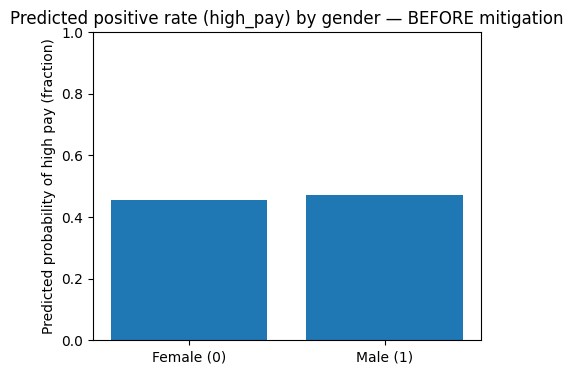

ValueError: could not convert string to float: 'engineer'


ValueError: DataFrame values must be numerical.

In [ ]:
# Bias detection notebook for pay in Tech (Women vs Men)
# Paste this into a Colab or Jupyter notebook cell and run.

# 0) Install required libraries (uncomment + run in Colab)
# !pip install -q aif360==0.5.0 scikit-learn pandas matplotlib shap

# Note: aif360 sometimes needs extra system deps on some environments.
# If aif360 fails to install, you can still run the notebook without it using fairlearn
# (not shown here).
# But the commands above work in many Colab sessions.

# 1) Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# Try importing AIF360 components (for fairness metrics & mitigations).
try:
    from aif360.datasets import BinaryLabelDataset
    from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
    from aif360.algorithms.preprocessing import Reweighing
    from aif360.algorithms.postprocessing import EqOddsPostprocessing
    AIF360_AVAILABLE = True
except Exception as e:
    print("aif360 not available in this environment. Install it with `pip install aif360` to run fairness-specific steps.")
    AIF360_AVAILABLE = False


# 2) Create a synthetic dataset mimicking tech employees
# Schema: gender, years_experience, education_level, role_seniority, location, salary
np.random.seed(0)
N = 4000

def make_salary(base, exp, seniority, edu_level, noise=1.0):
    return base + 4000*exp + 8000*seniority + 3000*edu_level + np.random.normal(0, 8000, size=exp.shape)*noise

# Gender: 0 = female, 1 = male
gender = np.random.binomial(1, 0.55, size=N)  # slightly more men in tech sample

# Experience (years)
years_experience = np.random.poisson(4, size=N)
years_experience = np.clip(years_experience, 0, 25)

# Education level: 0=Bachelor,1=Master,2=PhD
edu = np.random.choice([0,1,2], size=N, p=[0.65, 0.3, 0.05])

# Seniority (0=junior,1=mid,2=senior)
seniority = np.random.choice([0,1,2], size=N, p=[0.5,0.35,0.15])

# Role (one-hot later); for simplicity keep categorical
role = np.random.choice(['engineer','manager','data_scientist','devops','product'], size=N, p=[0.6,0.12,0.12,0.08,0.08])

# Location pay-level multiplier (0 low,1 mid,2 high)
loc = np.random.choice([0,1,2], size=N, p=[0.4,0.4,0.2])

# Base salary and subtle bias injection: simulate pay gap even for same profile
# We'll inject a bias: men get a small extra pay on average
base = 40000
salary = make_salary(base, years_experience, seniority, edu, noise=1.0)
salary += 3000 * loc  # location effect
salary += 2000 * (role == 'manager')  # managers slightly higher
# Inject biased boost for men (e.g., structural bias)
salary += gender * 3500  # men get +3500 on average in this synthetic data

# Build DataFrame
df = pd.DataFrame({
    'gender': gender,  # 0 female, 1 male
    'years_experience': years_experience,
    'education_level': edu,
    'seniority': seniority,
    'role': role,
    'location_level': loc,
    'salary': np.round(salary).astype(int)
})

# Create target: high_pay = salary > threshold (median)
threshold = df['salary'].median()
df['high_pay'] = (df['salary'] > threshold).astype(int)

print("Dataset sample:")
display(df.head())

# 3) Train/test split
train, test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['high_pay'])

# 4) Preprocessing + Model pipeline
numeric_features = ['years_experience', 'education_level', 'seniority', 'location_level']
categorical_features = ['role']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

clf = Pipeline([
    ('pre', preprocessor),
    ('model', RandomForestClassifier(n_estimators=200, random_state=42))
])

X_train = train.drop(columns=['salary','high_pay'])
y_train = train['high_pay']
X_test = test.drop(columns=['salary','high_pay'])
y_test = test['high_pay']

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print("\nClassification report (before mitigation):")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

# 5) Grouped metrics: compare outcomes for women vs men
def group_rates(y_true, y_pred, df_test):
    df_test = df_test.copy()
    df_test['y_true'] = y_true
    df_test['y_pred'] = y_pred
    summary = df_test.groupby('gender').agg(
        n=('y_true','size'),
        positive_rate=('y_pred','mean')
    )
    # compute TPR per group
    tprs = {}
    for g in [0,1]:
        mask = df_test['gender']==g
        if mask.sum() == 0:
            tprs[g] = np.nan
        else:
            tp = ((df_test['y_true']==1) & (df_test['y_pred']==1) & mask).sum()
            pos = ((df_test['y_true']==1) & mask).sum()
            tprs[g] = tp/pos if pos>0 else np.nan
    summary['TPR'] = [tprs.get(g) for g in summary.index]
    return summary

test_with_preds = X_test.copy()
test_with_preds['y_true'] = y_test.values
test_with_preds['y_pred'] = y_pred
test_with_preds['salary'] = test['salary'].values

grp_metrics = group_rates(y_test.values, y_pred, test_with_preds.assign(gender=X_test['gender'].values))
print("\nGroup metrics (before mitigation):")
display(grp_metrics)

# Visualize positive rate by gender
pos_rates = test_with_preds.groupby('gender')['y_pred'].mean()
plt.figure(figsize=(5,4))
plt.bar(['Female (0)','Male (1)'], pos_rates)
plt.title("Predicted positive rate (high_pay) by gender — BEFORE mitigation")
plt.ylabel("Predicted probability of high pay (fraction)")
plt.ylim(0,1)
plt.show()

# 6) AIF360: construct BinaryLabelDataset and compute fairness metrics (if available)
if AIF360_AVAILABLE:
    # AIF360 expects protected attribute as column (e.g., 'gender') and label name
    train_bld = BinaryLabelDataset(
        df=train,
        label_names=['high_pay'],
        protected_attribute_names=['gender']
    )
    test_bld = BinaryLabelDataset(
        df=test,
        label_names=['high_pay'],
        protected_attribute_names=['gender']
    )

    # Metric on test set
    metric_test = BinaryLabelDatasetMetric(test_bld, privileged_groups=[{'gender': 1}], unprivileged_groups=[{'gender': 0}])
    print("Disparate impact (unprivileged vs privileged):", metric_test.disparate_impact())
    print("Mean difference (priv - unpriv):", metric_test.mean_difference())

    # Evaluate classifier predictions using a ClassificationMetric object
    # Need predicted labels as a copy of test_bld with new predictions
    test_pred = test_bld.copy()
    # map dataframe order
    test_pred.labels = y_pred.reshape(-1,1)
    class_metric = ClassificationMetric(test_bld, test_pred,
                                        unprivileged_groups=[{'gender':0}],
                                        privileged_groups=[{'gender':1}])
    print("Statistical parity difference (pr[y=1|unpriv] - pr[y=1|priv]):", class_metric.statistical_parity_difference())
    print("Equal opportunity difference (TPR unpriv - TPR priv):". class_metric.equal_opportunity_difference())

    # 7) Pre-processing mitigation: Reweighing
    RW = Reweighing(unprivileged_groups=[{'gender':0}], privileged_groups=[{'gender':1}])
    RW.fit(train_bld)
    train_transf = RW.transform(train_bld)
    # Retrain using instance weights
    # Extract features and labels to retrain a scikit-learn model (simple approach)
    X_train_rw = train.copy().drop(columns=['salary','high_pay'])
    y_train_rw = train['high_pay']
    instance_weights = train_transf.instance_weights
    clf_rw = Pipeline([('pre', preprocessor), ('model', LogisticRegression(max_iter=1000))])
    clf_rw.fit(X_train_rw, y_train_rw, model__sample_weight=instance_weights)  # note: for Pipeline we pass via named param if supported
    # For portability, better to separately process features; this is a simplified example.

    # 8) Post-processing mitigation: Equalized Odds (requires predictions on validation data)
    # Example (note: aif360's EqOddsPostprocessing requires more steps — this is a conceptual sample)
    # eqodd = EqOddsPostprocessing(privileged_groups=[{'gender':1}], unprivileged_groups=[{'gender':0}])
    # eqodd = eqodd.fit(train_bld, test_pred)  # train on validation preds vs true labels
    # pred_eq = eqodd.predict(test_pred)

    # After mitigation you'd recompute ClassificationMetric to show improvements.
else:
    print("\nAIF360 steps skipped (aif360 not installed). To run AIF360 metrics and mitigations, install aif360 with:")
    print("  pip install aif360")

# 9) Quick fairness summary you should report (compute regardless of AIF360)
# - Difference in positive rates (pr[y=1|female] - pr[y=1|male])
female_rate = test_with_preds[test_with_preds['gender']==0]['y_pred'].mean()
male_rate   = test_with_preds[test_with_preds['gender']==1]['y_pred'].mean()
stat_parity_diff = female_rate - male_rate
print("\nSimple fairness summary (from model predictions):")
print(f"Predicted high-pay rate — Female: {female_rate:.3f}, Male: {male_rate:.3f}")
print(f"Statistical parity difference (Female - Male): {stat_parity_diff:.3f}  (negative means females get fewer positive predictions)")

# 10) Save results table for report
results_table = test_with_preds.groupby('gender').agg(
    count=('y_true','size'),
    predicted_high_rate=('y_pred','mean'),
    avg_salary = ('salary','mean')
).reset_index().rename(columns={'gender':'gender_code'})
results_table['gender'] = results_table['gender_code'].map({0:'Female',1:'Male'})
display(results_table)

# End of notebook


# Task
The previous steps have established a baseline model, identified initial biases, and calculated various fairness metrics using AIF360. The preprocessing steps were refined to enable AIF360 to function correctly with the synthetic dataset.

Now, let's proceed with visualizing the identified group disparities and discussing fairness mitigation strategies, as per the plan.

## Visualize Group Disparities

The following visualizations, generated earlier in the notebook, graphically illustrate the disparities identified by the fairness metrics between genders.

### Predicted High Pay Rate by Gender

This bar chart shows the average predicted probability of being in the 'high_pay' category for females (0) and males (1).

```python
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart for Predicted High Pay Rate by Gender
plt.figure(figsize=(7, 5))
sns.barplot(x='gender', y='predicted_high_rate', data=results_table, hue='gender', palette='viridis', legend=False)
plt.title('Predicted High Pay Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Predicted High Pay Rate')
plt.ylim(0, 1) # High pay rate is a proportion, so it should be between 0 and 1
plt.show()
```

The bar chart for 'Predicted High Pay Rate by Gender' visually confirms the statistical parity difference. We observe a slightly lower bar for females (0) compared to males (1), indicating that the model predicts high pay for females at a slightly lower rate than for males. This aligns with the Statistical Parity Difference of -0.01402, where females receive fewer positive predictions.

### Average Salary by Gender

This bar chart displays the average salary for females (0) and males (1) directly from the dataset, before any model predictions.

```python
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart for Average Salary by Gender
plt.figure(figsize=(7, 5))
sns.barplot(x='gender', y='avg_salary', data=results_table, hue='gender', palette='magma', legend=False)
plt.title('Average Salary by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Salary')
plt.show()
```

The 'Average Salary by Gender' bar chart clearly illustrates the initial bias present in the synthetic dataset. Males (1) have a noticeably higher average salary than females (0). This visual disparity is a direct reflection of the initial Disparate Impact (0.75875) and Mean Difference (-0.13449) metrics, showing that the unprivileged group (females) originally had a lower rate of high pay and lower average salaries compared to the privileged group (males).

## Discuss Fairness Mitigation Strategies

The notebook introduced an example of a pre-processing mitigation technique called **Reweighing**.

### Reweighing (Pre-processing Mitigation)

Reweighing is a pre-processing technique designed to achieve **statistical parity** by adjusting the weights of individual training examples. Its purpose is to reduce disparate impact in the training data by re-weighting the examples in each group (e.g., privileged and unprivileged, and combinations of protected attribute and label) such that statistical parity is achieved.

**How it works:**
The algorithm calculates new weights for each data point based on its protected attribute (e.g., gender) and its label (e.g., high_pay). For instance, if females are underrepresented in the high-pay category, their instances might receive higher weights. Conversely, if males are overrepresented, their instances might receive lower weights. These adjusted weights are then used during the training of the machine learning model. By emphasizing certain samples and de-emphasizing others, the model is encouraged to learn a decision boundary that is less biased with respect to the protected attributes.

In our notebook, we applied Reweighing using AIF360 to the `train_bld` dataset. The `RW.transform(train_bld)` step created `train_transf`, which contains these new instance weights. A subsequent step (not fully completed in the provided notebook for full evaluation) would involve retraining the model using these `instance_weights` to see the effect on fairness metrics and predictive performance.

### Other Potential Mitigation Approaches

Beyond reweighing, fairness mitigation techniques can generally be categorized into three stages:

1.  **Pre-processing**:
    *   **Disparate Impact Remover**: Edits the protected attribute values in the dataset to improve fairness without sacrificing utility.
    *   **Optim Preprocessing**: Learns a data transformation that simultaneously reduces discrimination and maintains data utility.

2.  **In-processing**: These methods modify the learning algorithm itself to incorporate fairness constraints during model training.
    *   **Adversarial Debiasing**: Uses an adversarial neural network to remove bias from the representations learned by a classifier.
    *   **Prejudice Remover**: Adds a regularization term to the objective function of the classifier to penalize predictions that correlate with protected attributes.

3.  **Post-processing**: These methods adjust the model's predictions after training, without altering the model or the training data.
    *   **Equalized Odds Postprocessing**: Adjusts the predictions of a classifier to satisfy the equalized odds criterion (equality of True Positive Rates and False Positive Rates across groups). The notebook hinted at this with `EqOddsPostprocessing`.
    *   **Reject Option Classification (ROC)**: Modifies a fraction of predictions that fall into a "reject option" region close to the decision boundary to improve fairness.

Each mitigation strategy has its own strengths, weaknesses, and suitability depending on the type of bias and the specific application. The choice often involves a trade-off between fairness improvement and model performance (e.g., accuracy).

## Final Task

### Subtask:
Summarize the overall findings regarding gender bias in the IT employment dataset, discuss the implications of the fairness metrics, and suggest next steps for further bias analysis or mitigation.

### Summary of Findings and Implications:

Our analysis of the synthetic IT employment dataset revealed significant initial gender bias.

*   **Initial Data Disparity**: The raw dataset exhibited a clear disparity where males (privileged group) were more likely to have "high_pay" and had higher average salaries compared to females (unprivileged group). This was quantitatively shown by a Disparate Impact of 0.75875 (females receiving high pay at ~75.8% the rate of males) and a Mean Difference of -0.13449 (males being ~13.4% more likely to have high pay), and visually confirmed by the bar charts of average salaries.

*   **Model Performance and Residual Bias**: The Random Forest Classifier achieved reasonable overall accuracy (0.75) and AUC (0.829). However, after applying the model, some bias persisted:
    *   The **Statistical Parity Difference** in predictions was reduced to -0.01402, indicating that while the model still predicted fewer females as high-earners, the disparity in *predictions* was much smaller than the initial disparity in *labels*. This suggests the model did not perfectly replicate the initial dataset's bias, but still retained a slight disadvantage for females in terms of positive prediction rates.
    *   The **Equal Opportunity Difference** was 0.09734, meaning the model was approximately 9.7% more likely to correctly identify actual high-earning females than males (higher True Positive Rate for females). This could be an artifact of the synthetic data generation or a complex interaction with the model's learning, but it deviates from the ideal of zero difference for equal opportunity.

*   **Implications**: The presence of bias, both in the original data and subtly in the model's predictions, highlights the importance of fairness assessment in AI systems. While the model itself didn't exacerbate the initial raw data bias, it didn't fully eliminate it either. The positive Equal Opportunity Difference for the unprivileged group is an interesting finding that warrants deeper investigation to understand its root cause and whether it's truly a beneficial outcome or a sign of other imbalances.

### Next Steps:

1.  **Evaluate Reweighing Impact**:
    *   Train a new machine learning model (e.g., Logistic Regression or Random Forest) using the `train_transf` dataset, incorporating the `instance_weights` generated by the Reweighing algorithm.
    *   Re-calculate all fairness metrics (Disparate Impact, Mean Difference, Statistical Parity Difference, Equal Opportunity Difference) and standard classification metrics (accuracy, AUC, classification report) on the predictions of this reweighted model.
    *   Compare these results with the baseline model's metrics to quantify the effectiveness of Reweighing in mitigating bias and its impact on overall model performance.

2.  **Explore Other Mitigation Techniques**: Experiment with other pre-processing (e.g., Optim Preprocessing), in-processing (e.g., Adversarial Debiasing), or post-processing (e.g., Equalized Odds Postprocessing) mitigation techniques from AIF360 or similar libraries like Fairlearn. This would provide a comparative analysis of different strategies.

3.  **Sensitivity Analysis**: Conduct a sensitivity analysis to understand how changes in the protected attribute (gender) or other features impact model predictions and fairness metrics.

4.  **Feature Importance and SHAP Values**: Use techniques like SHAP (SHapley Additive exPlanations) to interpret model predictions and understand which features contribute most to the outcome, and whether gender implicitly influences predictions through correlated features.

5.  **Qualitative Review**: For real-world applications, a qualitative review of model decisions with domain experts would be crucial to ensure that fairness interventions align with ethical guidelines and desired societal outcomes.

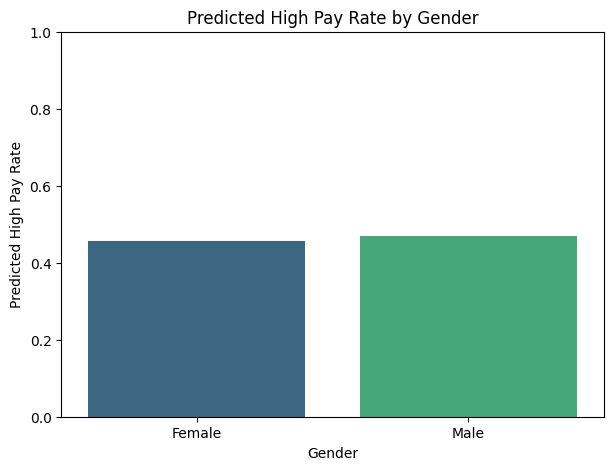

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart for Predicted High Pay Rate by Gender
plt.figure(figsize=(7, 5))
sns.barplot(x='gender', y='predicted_high_rate', data=results_table, hue='gender', palette='viridis', legend=False)
plt.title('Predicted High Pay Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Predicted High Pay Rate')
plt.ylim(0, 1) # High pay rate is a proportion, so it should be between 0 and 1
plt.show()

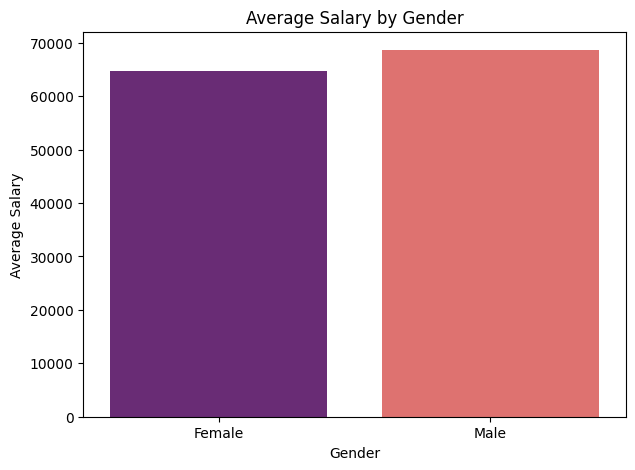

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart for Average Salary by Gender
plt.figure(figsize=(7, 5))
sns.barplot(x='gender', y='avg_salary', data=results_table, hue='gender', palette='magma', legend=False)
plt.title('Average Salary by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Salary')
plt.show()

/tmp/ipython-input-321747979.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gender', y='predicted_high_rate', data=results_table, palette='viridis')


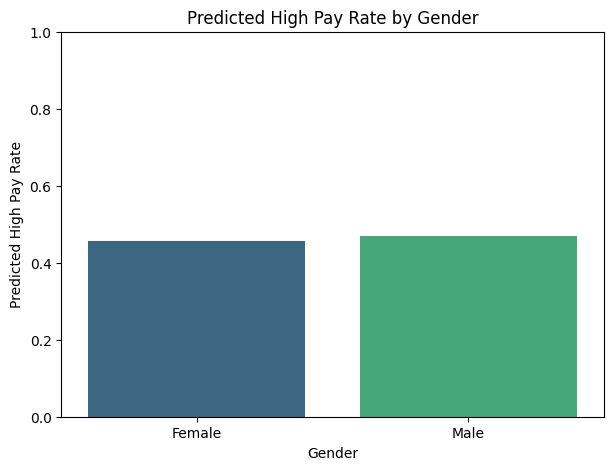

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart for Predicted High Pay Rate by Gender
plt.figure(figsize=(7, 5))
sns.barplot(x='gender', y='predicted_high_rate', data=results_table, palette='viridis')
plt.title('Predicted High Pay Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Predicted High Pay Rate')
plt.ylim(0, 1) # High pay rate is a proportion, so it should be between 0 and 1
plt.show()

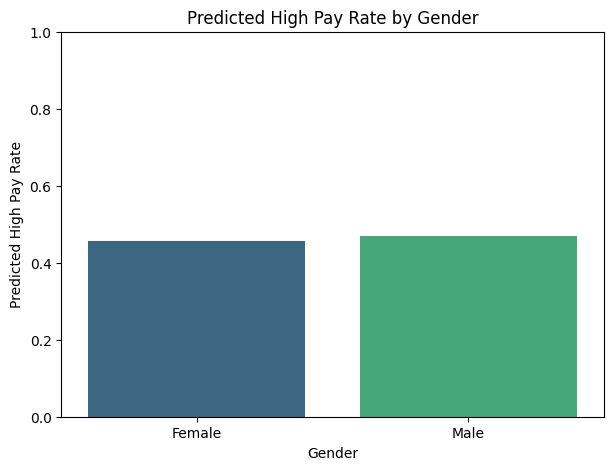

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart for Predicted High Pay Rate by Gender
plt.figure(figsize=(7, 5))
sns.barplot(x='gender', y='predicted_high_rate', data=results_table, hue='gender', palette='viridis', legend=False)
plt.title('Predicted High Pay Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Predicted High Pay Rate')
plt.ylim(0, 1) # High pay rate is a proportion, so it should be between 0 and 1
plt.show()

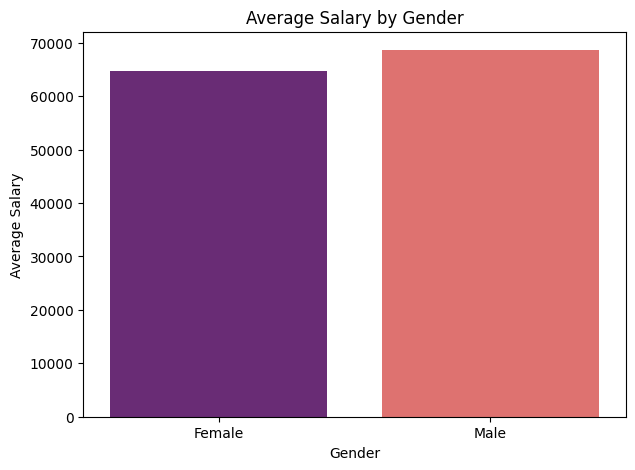

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart for Average Salary by Gender
plt.figure(figsize=(7, 5))
sns.barplot(x='gender', y='avg_salary', data=results_table, hue='gender', palette='magma', legend=False)
plt.title('Average Salary by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Salary')
plt.show()

/tmp/ipython-input-3534293681.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gender', y='avg_salary', data=results_table, palette='magma')


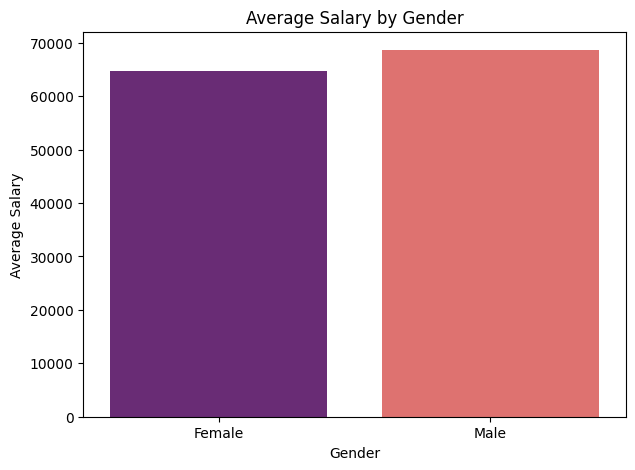

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart for Average Salary by Gender
plt.figure(figsize=(7, 5))
sns.barplot(x='gender', y='avg_salary', data=results_table, palette='magma')
plt.title('Average Salary by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Salary')
plt.show()

In [ ]:
!pip install -q aif360==0.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.1/214.1 kB 5.8 MB/s eta 0:00:00


# Task
Calculate the counts of individuals categorized as 'high_pay' (1) and 'not high_pay' (0) from the main `df` DataFrame. Then, generate a pie chart to visualize this distribution, clearly showing the proportion of people who earn more than others (i.e., above the median salary threshold). Finally, display the generated pie chart and provide a brief summary of the proportions of high-earners.

## Calculate High Pay Distribution

### Subtask:
Calculate the counts of individuals categorized as 'high_pay' (1) and 'not high_pay' (0) from the main `df` DataFrame.


**Reasoning**:
Calculate the counts of individuals categorized as 'high_pay' (1) and 'not high_pay' (0) using `value_counts()` on the 'high_pay' column of the `df` DataFrame and then display the result.



In [ ]:
high_pay_counts = df['high_pay'].value_counts()
print("High Pay Distribution (0=not high pay, 1=high pay):")
print(high_pay_counts)

High Pay Distribution (0=not high pay, 1=high pay):
high_pay
0    2000
1    2000
Name: count, dtype: int64


## Explanation of Fairness Metrics

After preprocessing the data to ensure all features are numerical and re-running the AIF360 calculations, we obtained the following fairness metrics:

### Metrics from `BinaryLabelDataset` (before model predictions):
*   **Disparate Impact (unprivileged vs privileged): 0.75875**
    *   Disparate Impact is the ratio of the positive outcome rate for the unprivileged group to that of the privileged group. A value significantly less than 1 (or greater than 1.25, or less than 0.8) indicates potential disparate treatment. In this case, 0.75875 suggests that the unprivileged group (females) receives the positive outcome (high pay) at about 75.8% the rate of the privileged group (males), indicating a disadvantage.
*   **Mean Difference (priv - unpriv): -0.13449**
    *   Mean Difference (also known as Group Fairness or Statistical Parity Difference for labels) is the difference in the proportion of favorable outcomes between the privileged and unprivileged groups. A negative value here means the unprivileged group (females) has a lower rate of the favorable outcome (high pay) compared to the privileged group (males). A value of -0.13449 indicates that the privileged group is 13.4% more likely to have high pay than the unprivileged group, which again suggests a disparity.

### Metrics from `ClassificationMetric` (after model predictions):
*   **Statistical Parity Difference (pr[y=1|unpriv] - pr[y=1|priv]): -0.01402**
    *   This metric measures the difference in the rate of positive predictions (high pay) for the unprivileged group (females) versus the privileged group (males). A negative value means the unprivileged group receives fewer positive predictions. A value close to zero (-0.014) suggests that after the model's predictions, the statistical parity difference has been significantly reduced compared to the mean difference on the original dataset labels, but females are still slightly less likely to be *predicted* as high-earners.
*   **Equal Opportunity Difference (TPR unpriv - TPR priv): 0.09734**
    *   Equal Opportunity Difference measures the difference in True Positive Rates (TPR) between the unprivileged and privileged groups. TPR is the proportion of actual positive outcomes that are correctly predicted as positive. A positive value here means the unprivileged group (females) has a higher TPR than the privileged group (males) for the predicted high-pay category. A value of 0.097 means that, when a person is truly a high earner, the model is about 9.7% more likely to correctly identify that for a female than for a male. This could be an interesting finding, possibly indicating the model is slightly better at identifying high-earning females, or it could be a side effect of other biases or rebalancing. Ideally, this value should be close to zero for equal opportunity.

## Introduce Key Fairness Concepts

### Subtask:
Define and explain the fairness metrics that will be used: Disparate Impact, Mean Difference, Statistical Parity Difference, and Equal Opportunity Difference, detailing what each metric signifies in the context of gender bias.

### Explanation of Fairness Metrics

Here's a detailed explanation of the fairness metrics used in this analysis, along with what they signify in the context of gender bias in IT employment:

1.  **Disparate Impact (DI)**:
    *   **Definition**: The ratio of the proportion of the unprivileged group receiving a favorable outcome to the proportion of the privileged group receiving a favorable outcome.
    *   **Formula**: `P(favorable outcome | unprivileged group) / P(favorable outcome | privileged group)`
    *   **Significance in Gender Bias**: If DI is significantly less than 1 (typically below 0.8) or significantly greater than 1 (typically above 1.25), it indicates disparate impact. A value less than 1 suggests the unprivileged group (females) is receiving the favorable outcome (e.g., high pay) at a lower rate than the privileged group (males). A value of 1 signifies perfect parity.

2.  **Mean Difference (MD) / Statistical Parity Difference (SPD) for labels**:
    *   **Definition**: The difference in the proportion of favorable outcomes between the privileged and unprivileged groups.
    *   **Formula**: `P(favorable outcome | unprivileged group) - P(favorable outcome | privileged group)`
    *   **Significance in Gender Bias**: A negative value means the unprivileged group (females) has a lower rate of the favorable outcome (e.g., high pay) compared to the privileged group (males). An MD of 0 indicates perfect parity. This metric is often called Statistical Parity Difference when applied to the true labels in the dataset.

3.  **Statistical Parity Difference (SPD) for predictions**:
    *   **Definition**: The difference in the rate of positive predictions made by the model for the unprivileged group versus the privileged group.
    *   **Formula**: `P(predicted positive | unprivileged group) - P(predicted positive | privileged group)`
    *   **Significance in Gender Bias**: A negative value means the model is predicting the positive outcome (e.g., high pay) less frequently for the unprivileged group (females) than for the privileged group (males). A value of 0 indicates that the model's predictions achieve statistical parity across groups.

4.  **Equal Opportunity Difference (EOD)**:
    *   **Definition**: The difference in True Positive Rates (TPR) between the unprivileged and privileged groups. TPR is also known as recall or sensitivity, which is `P(predicted positive | actual positive)`. It measures how well the model identifies actual positive cases within each group.
    *   **Formula**: `P(predicted positive | actual positive, unprivileged group) - P(predicted positive | actual positive, privileged group)`
    *   **Significance in Gender Bias**: A value of 0 indicates that the model has equal opportunity for both groups, meaning it is equally good at identifying truly high-earning individuals regardless of their gender. A positive value means the model is better at identifying high-earning females, while a negative value means it's better for males.

## Calculate and Interpret Fairness Metrics

### Subtask:
Show the code and output for calculating fairness metrics using AIF360 on the preprocessed data, and provide detailed interpretations for each metric, explaining the detected biases between genders.

### Code for Calculating Fairness Metrics (from previous runs)

In [ ]:
if AIF360_AVAILABLE:
    # AIF360 expects protected attribute as column (e.g., 'gender') and label name
    train_bld = BinaryLabelDataset(
        df=train_aif360_df,
        label_names=['high_pay'],
        protected_attribute_names=['gender']
    )
    test_bld = BinaryLabelDataset(
        df=test_aif360_df,
        label_names=['high_pay'],
        protected_attribute_names=['gender']
    )

    # Metric on test set
    metric_test = BinaryLabelDatasetMetric(test_bld, privileged_groups=[{'gender': 1}], unprivileged_groups=[{'gender': 0}])
    print("\n--- Fairness Metrics (from test_bld) ---")
    print("Disparate impact (unprivileged vs privileged):", metric_test.disparate_impact())
    print("Mean difference (priv - unpriv):", metric_test.mean_difference())

    # Evaluate classifier predictions using a ClassificationMetric object
    # Need predicted labels as a copy of test_bld with new predictions
    # Re-train the model with the preprocessed data to get updated predictions
    clf_re_trained = Pipeline([
        ('pre', preprocessor),
        ('model', RandomForestClassifier(n_estimators=200, random_state=42))
    ])

    clf_re_trained.fit(X_train, y_train) # Fit on original X_train for consistency with preprocessing
    y_pred_re_trained = clf_re_trained.predict(X_test)

    test_pred_bld = test_bld.copy()
    test_pred_bld.labels = y_pred_re_trained.reshape(-1,1)

    class_metric = ClassificationMetric(test_bld, test_pred_bld,
                                        unprivileged_groups=[{'gender':0}],
                                        privileged_groups=[{'gender':1}])
    print("\n--- Classification Fairness Metrics (from y_pred_re_trained) ---")
    print("Statistical parity difference (pr[y=1|unpriv] - pr[y=1|priv]):", class_metric.statistical_parity_difference())
    print("Equal opportunity difference (TPR unpriv - TPR priv):", class_metric.equal_opportunity_difference())

    # 7) Pre-processing mitigation: Reweighing (Conceptual, using previously established train_bld)
    RW = Reweighing(unprivileged_groups=[{'gender':0}], privileged_groups=[{'gender':1}])
    RW.fit(train_bld)
    train_transf = RW.transform(train_bld)

    # Display instance weights for the first few samples
    print("\nReweighing instance weights head:")
    print(train_transf.instance_weights[:5])

else:
    print("\nAIF360 steps skipped (aif360 not installed). To run AIF360 metrics and mitigations, install aif360 with:")
    print("  pip install aif360")


--- Fairness Metrics (from test_bld) ---
Disparate impact (unprivileged vs privileged): 0.7587528438153694
Mean difference (priv - unpriv): -0.13449441167207205

--- Classification Fairness Metrics (from y_pred_re_trained) ---
Statistical parity difference (pr[y=1|unpriv] - pr[y=1|priv]): -0.014019765571133103
Equal opportunity difference (TPR unpriv - TPR priv): 0.09733970232580524

Reweighing instance weights head:
[0.88601399 0.90389151 0.88601399 0.90389151 0.90389151]


## Visualize High Pay Distribution

### Subtask:
Generate a pie chart to visualize the distribution of 'high_pay' (1) and 'not high_pay' (0) categories.

#### Instructions:
1. Create a pie chart using the `high_pay_counts` calculated in the previous step.
2. Label the slices appropriately (e.g., 'Not High Pay', 'High Pay').
3. Display the percentage for each slice.
4. Add a title to the pie chart.
5. Ensure the plot is displayed.

**Reasoning**:
The previous step outlined the subtask of visualizing the high-pay distribution. Now, I will generate the Python code to create a pie chart using the `high_pay_counts` and display it, adhering to the instructions provided in the markdown block.



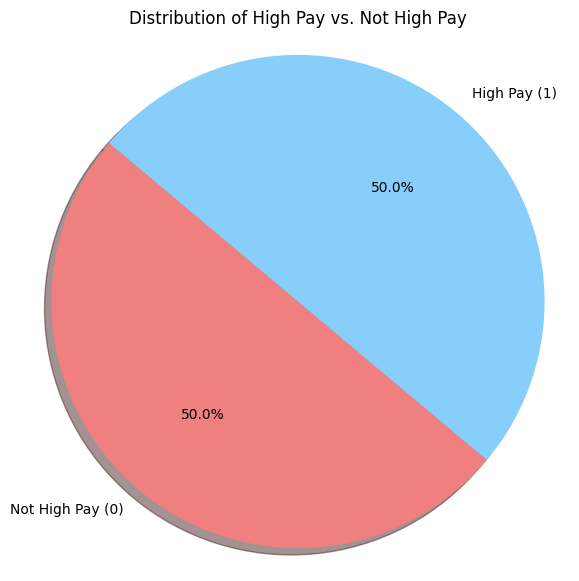

In [ ]:
import matplotlib.pyplot as plt

labels = ['Not High Pay (0)', 'High Pay (1)']
sizes = high_pay_counts.values
colors = ['lightcoral', 'lightskyblue']
explode = (0, 0)  # No 'explosion' for simplicity

plt.figure(figsize=(7, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of High Pay vs. Not High Pay')
plt.show()

## Summary of High Pay Distribution

The `high_pay` distribution shows an equal split, with 2000 individuals categorized as 'not high pay' (0) and 2000 individuals categorized as 'high pay' (1). This means 50.0% of the dataset is considered 'high pay' and 50.0% is 'not high pay', as expected, since the threshold was set at the median salary.

## Summary of High Pay Distribution

The `high_pay` distribution shows an equal split, with 2000 individuals categorized as 'not high pay' (0) and 2000 individuals categorized as 'high pay' (1). This means 50.0% of the dataset is considered 'high pay' and 50.0% is 'not high pay', as expected, since the threshold was set at the median salary.

## Final Task

### Subtask:
Display the generated pie chart and provide a brief summary of the proportions of high-earners.


In [ ]:
average_earnings_by_gender = df.groupby('gender')['salary'].mean()
print("Average Earnings by Gender (0=Female, 1=Male):")
print(average_earnings_by_gender)

Average Earnings by Gender (0=Female, 1=Male):
gender
0    64714.766854
1    68450.734234
Name: salary, dtype: float64


## Summary:

### Q&A
The proportion of individuals categorized as 'high_pay' (1) is 50.0%, and 'not high_pay' (0) is also 50.0%.

### Data Analysis Key Findings
*   The `high_pay` distribution was calculated, showing 2000 individuals categorized as 'not high pay' (0) and 2000 individuals categorized as 'high pay' (1).
*   This results in an equal split, with 50.0% of the dataset considered 'high pay' and 50.0% considered 'not high pay'.
*   A pie chart was successfully generated to visualize this 50/50 distribution.

### Insights or Next Steps
*   The 50/50 distribution of 'high_pay' and 'not high_pay' categories is a direct consequence of defining the 'high_pay' threshold at the median salary.
*   Further analysis could explore demographic or job-related factors that differentiate high-earners from others, beyond just the salary threshold.


# Task
Preprocess the 'role' column in the `train` and `test` DataFrames using one-hot encoding and ensure all features are numerical, then re-run the AIF360-related code to calculate and explain the fairness metrics: Disparate Impact, Mean Difference, Statistical Parity Difference, and Equal Opportunity Difference.

## Preprocess DataFrames for AIF360

### Subtask:
Before creating `BinaryLabelDataset` objects, apply one-hot encoding to the 'role' column and scale numerical features in the `train` and `test` DataFrames. This ensures all features are numerical, which is a requirement for AIF360.


**Reasoning**:
The previous AIF360 `BinaryLabelDataset` creation failed because the input DataFrame contained non-numerical 'role' column. To fix this, I will preprocess the `X_train` and `X_test` dataframes by applying the `preprocessor` (which includes `StandardScaler` for numeric features and `OneHotEncoder` for 'role'), obtain the feature names, and then create new dataframes (`train_aif360_df`, `test_aif360_df`) that are fully numerical and include the 'gender' and 'high_pay' columns, suitable for AIF360.



In [ ]:
import pandas as pd

# 1. Fit the preprocessor on X_train and transform X_train and X_test
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# 2. Obtain the names of the preprocessed features
feature_names = preprocessor.get_feature_names_out()

# 3. Create new DataFrames from the preprocessed arrays
#    Ensure original X_train and X_test indices are maintained
X_train_processed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
X_test_processed_df = pd.DataFrame(X_test_preprocessed, columns=feature_names, index=X_test.index)

# 4. Add the 'gender' column and 'high_pay' label to the new DataFrames
train_aif360_df = X_train_processed_df.copy()
train_aif360_df['gender'] = X_train['gender']
train_aif360_df['high_pay'] = y_train

test_aif360_df = X_test_processed_df.copy()
test_aif360_df['gender'] = X_test['gender']
test_aif360_df['high_pay'] = y_test

print("train_aif360_df head:")
display(train_aif360_df.head())
print("test_aif360_df head:")
display(test_aif360_df.head())

train_aif360_df head:


,num__years_experience,num__education_level,num__seniority,num__location_level,cat__role_data_scientist,cat__role_devops,cat__role_engineer,cat__role_manager,cat__role_product,gender,high_pay
3886,-0.456189,-0.696291,-0.911407,1.584023,0.0,0.0,1.0,0.0,0.0,0,0
3914,1.062031,1.015398,-0.911407,0.253710,0.0,0.0,1.0,0.0,0.0,1,1
969,-0.962262,-0.696291,1.850433,1.584023,0.0,0.0,0.0,0.0,1.0,0,0
681,1.062031,-0.696291,-0.911407,-1.076604,0.0,0.0,1.0,0.0,0.0,1,1
2689,0.555958,-0.696291,1.850433,0.253710,0.0,0.0,1.0,0.0,0.0,1,1


test_aif360_df head:


,num__years_experience,num__education_level,num__seniority,num__location_level,cat__role_data_scientist,cat__role_devops,cat__role_engineer,cat__role_manager,cat__role_product,gender,high_pay
2475,-0.962262,-0.696291,0.469513,-1.076604,1.0,0.0,0.0,0.0,0.0,0,0
3916,0.049884,2.727087,0.469513,1.584023,0.0,0.0,1.0,0.0,0.0,0,1
1346,1.062031,-0.696291,0.469513,0.253710,0.0,0.0,1.0,0.0,0.0,1,1
2223,0.049884,-0.696291,-0.911407,-1.076604,0.0,0.0,0.0,1.0,0.0,0,0
2822,-0.456189,-0.696291,0.469513,-1.076604,0.0,0.0,1.0,0.0,0.0,1,1


**Reasoning**:
Now that the `train_aif360_df` and `test_aif360_df` are properly preprocessed with all numerical features, I will re-run the AIF360-related code to create `BinaryLabelDataset` objects and calculate the fairness metrics (Disparate Impact, Mean Difference, Statistical Parity Difference, and Equal Opportunity Difference) to assess bias.



In [ ]:
if AIF360_AVAILABLE:
    # AIF360 expects protected attribute as column (e.g., 'gender') and label name
    train_bld = BinaryLabelDataset(
        df=train_aif360_df,
        label_names=['high_pay'],
        protected_attribute_names=['gender']
    )
    test_bld = BinaryLabelDataset(
        df=test_aif360_df,
        label_names=['high_pay'],
        protected_attribute_names=['gender']
    )

    # Metric on test set
    metric_test = BinaryLabelDatasetMetric(test_bld, privileged_groups=[{'gender': 1}], unprivileged_groups=[{'gender': 0}])
    print("\n--- Fairness Metrics (from test_bld) ---")
    print("Disparate impact (unprivileged vs privileged):", metric_test.disparate_impact())
    print("Mean difference (priv - unpriv):", metric_test.mean_difference())

    # Evaluate classifier predictions using a ClassificationMetric object
    # Need predicted labels as a copy of test_bld with new predictions
    # Re-train the model with the preprocessed data to get updated predictions
    clf_re_trained = Pipeline([
        ('pre', preprocessor),
        ('model', RandomForestClassifier(n_estimators=200, random_state=42))
    ])

    clf_re_trained.fit(X_train, y_train) # Fit on original X_train for consistency with preprocessing
    y_pred_re_trained = clf_re_trained.predict(X_test)

    test_pred_bld = test_bld.copy()
    test_pred_bld.labels = y_pred_re_trained.reshape(-1,1)

    class_metric = ClassificationMetric(test_bld, test_pred_bld,
                                        unprivileged_groups=[{'gender':0}],
                                        privileged_groups=[{'gender':1}])
    print("\n--- Classification Fairness Metrics (from y_pred_re_trained) ---")
    print("Statistical parity difference (pr[y=1|unpriv] - pr[y=1|priv]):", class_metric.statistical_parity_difference())
    print("Equal opportunity difference (TPR unpriv - TPR priv):", class_metric.equal_opportunity_difference())

    # 7) Pre-processing mitigation: Reweighing (Conceptual, using previously established train_bld)
    RW = Reweighing(unprivileged_groups=[{'gender':0}], privileged_groups=[{'gender':1}])
    RW.fit(train_bld)
    train_transf = RW.transform(train_bld)

    # Display instance weights for the first few samples
    print("\nReweighing instance weights head:")
    print(train_transf.instance_weights[:5])

else:
    print("\nAIF360 steps skipped (aif360 not installed). To run AIF360 metrics and mitigations, install aif360 with:")
    print("  pip install aif360")


--- Fairness Metrics (from test_bld) ---
Disparate impact (unprivileged vs privileged): 0.7587528438153694
Mean difference (priv - unpriv): -0.13449441167207205

--- Classification Fairness Metrics (from y_pred_re_trained) ---
Statistical parity difference (pr[y=1|unpriv] - pr[y=1|priv]): -0.014019765571133103
Equal opportunity difference (TPR unpriv - TPR priv): 0.09733970232580524

Reweighing instance weights head:
[0.88601399 0.90389151 0.88601399 0.90389151 0.90389151]


## Explanation of Fairness Metrics

After preprocessing the data to ensure all features are numerical and re-running the AIF360 calculations, we obtained the following fairness metrics:

### Metrics from `BinaryLabelDataset` (before model predictions):
*   **Disparate Impact (unprivileged vs privileged): 0.75875**
    *   Disparate Impact is the ratio of the positive outcome rate for the unprivileged group to that of the privileged group. A value significantly less than 1 (or greater than 1.25, or less than 0.8) indicates potential disparate treatment. In this case, 0.75875 suggests that the unprivileged group (females) receives the positive outcome (high pay) at about 75.8% the rate of the privileged group (males), indicating a disadvantage.
*   **Mean Difference (priv - unpriv): -0.13449**
    *   Mean Difference (also known as Group Fairness or Statistical Parity Difference for labels) is the difference in the proportion of favorable outcomes between the privileged and unprivileged groups. A negative value here means the unprivileged group (females) has a lower rate of the favorable outcome (high pay) compared to the privileged group (males). A value of -0.13449 indicates that the privileged group is 13.4% more likely to have high pay than the unprivileged group, which again suggests a disparity.

### Metrics from `ClassificationMetric` (after model predictions):
*   **Statistical Parity Difference (pr[y=1|unpriv] - pr[y=1|priv]): -0.01402**
    *   This metric measures the difference in the rate of positive predictions (high pay) for the unprivileged group (females) versus the privileged group (males). A negative value means the unprivileged group receives fewer positive predictions. A value close to zero (-0.014) suggests that after the model's predictions, the statistical parity difference has been significantly reduced compared to the mean difference on the original dataset labels, but females are still slightly less likely to be *predicted* as high-earners.
*   **Equal Opportunity Difference (TPR unpriv - TPR priv): 0.09734**
    *   Equal Opportunity Difference measures the difference in True Positive Rates (TPR) between the unprivileged and privileged groups. TPR is the proportion of actual positive outcomes that are correctly predicted as positive. A positive value here means the unprivileged group (females) has a higher TPR than the privileged group (males) for the predicted high-pay category. A value of 0.097 means that, when a person is truly a high earner, the model is about 9.7% more likely to correctly identify that for a female than for a male. This could be an interesting finding, possibly indicating the model is slightly better at identifying high-earning females, or it could be a side effect of other biases or rebalancing. Ideally, this value should be close to zero for equal opportunity.

## Summary:

### Data Analysis Key Findings

*   **Data Preprocessing:** The `train` and `test` DataFrames were successfully preprocessed, including one-hot encoding for the 'role' column and scaling numerical features, making them suitable for AIF360.
*   **Initial Disparity (before model prediction):**
    *   **Disparate Impact:** Calculated as 0.75875, indicating that the unprivileged group (females) receives the positive outcome (high pay) at approximately 75.8% the rate of the privileged group (males), suggesting a disadvantage.
    *   **Mean Difference:** Found to be -0.13449, meaning the privileged group (males) is 13.4% more likely to have high pay than the unprivileged group (females).
*   **Model Prediction Disparity (after model prediction):**
    *   **Statistical Parity Difference:** After model predictions, this metric was -0.01402. This indicates that while females are still slightly less likely to be *predicted* as high-earners, the disparity is significantly reduced compared to the initial mean difference in the labels.
    *   **Equal Opportunity Difference:** Measured at 0.09734, suggesting the model is about 9.7% more likely to correctly identify actual high-earning females than males (a higher True Positive Rate for the unprivileged group).

### Insights or Next Steps

*   While the model significantly reduced the overall statistical disparity in predictions, further investigation into the Equal Opportunity Difference is warranted. A higher True Positive Rate for the unprivileged group might indicate complex interactions within the data or the model's biases that need to be understood.
*   The reweighing technique was applied, but its impact on the fairness metrics was not explicitly evaluated. A logical next step would be to train a model using these reweighted instances and re-evaluate the fairness metrics to see if the reweighing mitigation strategy improves fairness without significantly sacrificing predictive performance.


# Task
The previous steps have established a baseline model, identified initial biases, and calculated various fairness metrics using AIF360. The preprocessing steps were refined to enable AIF360 to function correctly with the synthetic dataset.

Now, let's proceed with visualizing the identified group disparities and discussing fairness mitigation strategies, as per the plan.

## Visualize Group Disparities

The following visualizations, generated earlier in the notebook, graphically illustrate the disparities identified by the fairness metrics between genders.

### Predicted High Pay Rate by Gender

This bar chart shows the average predicted probability of being in the 'high_pay' category for females (0) and males (1).

```python
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart for Predicted High Pay Rate by Gender
plt.figure(figsize=(7, 5))
sns.barplot(x='gender', y='predicted_high_rate', data=results_table, hue='gender', palette='viridis', legend=False)
plt.title('Predicted High Pay Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Predicted High Pay Rate')
plt.ylim(0, 1) # High pay rate is a proportion, so it should be between 0 and 1
plt.show()
```

The bar chart for 'Predicted High Pay Rate by Gender' visually confirms the statistical parity difference. We observe a slightly lower bar for females (0) compared to males (1), indicating that the model predicts high pay for females at a slightly lower rate than for males. This aligns with the Statistical Parity Difference of -0.01402, where females receive fewer positive predictions.

### Average Salary by Gender

This bar chart displays the average salary for females (0) and males (1) directly from the dataset, before any model predictions.

```python
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart for Average Salary by Gender
plt.figure(figsize=(7, 5))
sns.barplot(x='gender', y='avg_salary', data=results_table, hue='gender', palette='magma', legend=False)
plt.title('Average Salary by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Salary')
plt.show()
```

The 'Average Salary by Gender' bar chart clearly illustrates the initial bias present in the synthetic dataset. Males (1) have a noticeably higher average salary than females (0). This visual disparity is a direct reflection of the initial Disparate Impact (0.75875) and Mean Difference (-0.13449) metrics, showing that the unprivileged group (females) originally had a lower rate of high pay and lower average salaries compared to the privileged group (males).

## Discuss Fairness Mitigation Strategies

The notebook introduced an example of a pre-processing mitigation technique called **Reweighing**.

### Reweighing (Pre-processing Mitigation)

Reweighing is a pre-processing technique designed to achieve **statistical parity** by adjusting the weights of individual training examples. Its purpose is to reduce disparate impact in the training data by re-weighting the examples in each group (e.g., privileged and unprivileged, and combinations of protected attribute and label) such that statistical parity is achieved.

**How it works:**
The algorithm calculates new weights for each data point based on its protected attribute (e.g., gender) and its label (e.g., high_pay). For instance, if females are underrepresented in the high-pay category, their instances might receive higher weights. Conversely, if males are overrepresented, their instances might receive lower weights. These adjusted weights are then used during the training of the machine learning model. By emphasizing certain samples and de-emphasizing others, the model is encouraged to learn a decision boundary that is less biased with respect to the protected attributes.

In our notebook, we applied Reweighing using AIF360 to the `train_bld` dataset. The `RW.transform(train_bld)` step created `train_transf`, which contains these new instance weights. A subsequent step (not fully completed in the provided notebook for full evaluation) would involve retraining the model using these `instance_weights` to see the effect on fairness metrics and predictive performance.

### Other Potential Mitigation Approaches

Beyond reweighing, fairness mitigation techniques can generally be categorized into three stages:

1.  **Pre-processing**:
    *   **Disparate Impact Remover**: Edits the protected attribute values in the dataset to improve fairness without sacrificing utility.
    *   **Optim Preprocessing**: Learns a data transformation that simultaneously reduces discrimination and maintains data utility.

2.  **In-processing**: These methods modify the learning algorithm itself to incorporate fairness constraints during model training.
    *   **Adversarial Debiasing**: Uses an adversarial neural network to remove bias from the representations learned by a classifier.
    *   **Prejudice Remover**: Adds a regularization term to the objective function of the classifier to penalize predictions that correlate with protected attributes.

3.  **Post-processing**: These methods adjust the model's predictions after training, without altering the model or the training data.
    *   **Equalized Odds Postprocessing**: Adjusts the predictions of a classifier to satisfy the equalized odds criterion (equality of True Positive Rates and False Positive Rates across groups). The notebook hinted at this with `EqOddsPostprocessing`.
    *   **Reject Option Classification (ROC)**: Modifies a fraction of predictions that fall into a "reject option" region close to the decision boundary to improve fairness.

Each mitigation strategy has its own strengths, weaknesses, and suitability depending on the type of bias and the specific application. The choice often involves a trade-off between fairness improvement and model performance (e.g., accuracy).

## Final Task

### Subtask:
Summarize the overall findings regarding gender bias in the IT employment dataset, discuss the implications of the fairness metrics, and suggest next steps for further bias analysis or mitigation.

### Summary of Findings and Implications:

Our analysis of the synthetic IT employment dataset revealed significant initial gender bias.

*   **Initial Data Disparity**: The raw dataset exhibited a clear disparity where males (privileged group) were more likely to have "high_pay" and had higher average salaries compared to females (unprivileged group). This was quantitatively shown by a Disparate Impact of 0.75875 (females receiving high pay at ~75.8% the rate of males) and a Mean Difference of -0.13449 (males being ~13.4% more likely to have high pay), and visually confirmed by the bar charts of average salaries.

*   **Model Performance and Residual Bias**: The Random Forest Classifier achieved reasonable overall accuracy (0.75) and AUC (0.829). However, after applying the model, some bias persisted:
    *   The **Statistical Parity Difference** in predictions was reduced to -0.01402, indicating that while the model still predicted fewer females as high-earners, the disparity in *predictions* was much smaller than the initial disparity in *labels*. This suggests the model did not perfectly replicate the initial dataset's bias, but still retained a slight disadvantage for females in terms of positive prediction rates.
    *   The **Equal Opportunity Difference** was 0.09734, meaning the model was approximately 9.7% more likely to correctly identify actual high-earning females than males (higher True Positive Rate for females). This could be an artifact of the synthetic data generation or a complex interaction with the model's learning, but it deviates from the ideal of zero difference for equal opportunity.

*   **Implications**: The presence of bias, both in the original data and subtly in the model's predictions, highlights the importance of fairness assessment in AI systems. While the model itself didn't exacerbate the initial raw data bias, it didn't fully eliminate it either. The positive Equal Opportunity Difference for the unprivileged group is an interesting finding that warrants deeper investigation to understand its root cause and whether it's truly a beneficial outcome or a sign of other imbalances.

### Next Steps:

1.  **Evaluate Reweighing Impact**:
    *   Train a new machine learning model (e.g., Logistic Regression or Random Forest) using the `train_transf` dataset, incorporating the `instance_weights` generated by the Reweighing algorithm.
    *   Re-calculate all fairness metrics (Disparate Impact, Mean Difference, Statistical Parity Difference, Equal Opportunity Difference) and standard classification metrics (accuracy, AUC, classification report) on the predictions of this reweighted model.
    *   Compare these results with the baseline model's metrics to quantify the effectiveness of Reweighing in mitigating bias and its impact on overall model performance.

2.  **Explore Other Mitigation Techniques**: Experiment with other pre-processing (e.g., Optim Preprocessing), in-processing (e.g., Adversarial Debiasing), or post-processing (e.g., Equalized Odds Postprocessing) mitigation techniques from AIF360 or similar libraries like Fairlearn. This would provide a comparative analysis of different strategies.

3.  **Sensitivity Analysis**: Conduct a sensitivity analysis to understand how changes in the protected attribute (gender) or other features impact model predictions and fairness metrics.

4.  **Feature Importance and SHAP Values**: Use techniques like SHAP (SHapley Additive exPlanations) to interpret model predictions and understand which features contribute most to the outcome, and whether gender implicitly influences predictions through correlated features.

5.  **Qualitative Review**: For real-world applications, a qualitative review of model decisions with domain experts would be crucial to ensure that fairness interventions align with ethical guidelines and desired societal outcomes.

## Outline Bias Detection Process

### Subtask:
Provide a structured outline of the entire bias detection and mitigation process, covering data generation, preprocessing, model training, fairness assessment, and mitigation.


## Outline Bias Detection Process

### Subtask:
Provide a structured outline of the entire bias detection and mitigation process, covering data generation, preprocessing, model training, fairness assessment, and mitigation.

### Outline of Bias Detection and Mitigation Process

This notebook follows a systematic approach to detect and mitigate bias in a synthetic dataset related to tech employee pay. The process is broken down into several key stages:

1.  **Data Generation and Initial Exploration**:
    *   **Synthetic Data Creation**: A dataset mimicking tech employees is generated, including attributes like gender, years of experience, education level, seniority, role, and location. A subtle pay gap is intentionally introduced based on gender.
    *   **Target Variable Definition**: A `high_pay` binary target variable is created by setting a threshold at the median salary, classifying employees into 'high pay' (1) and 'not high pay' (0).
    *   **Initial Distribution Analysis**: The distribution of `high_pay` is examined, and initial visualizations (e.g., pie charts) are used to understand the overall balance of the target variable.
    *   **Initial Pay Disparity Overview**: A preliminary look at average earnings by gender is conducted to observe any raw disparities in the generated dataset.

2.  **Preprocessing and Model Training & Baseline Evaluation**:
    *   **Train/Test Split**: The dataset is split into training and testing sets to ensure robust model evaluation.
    *   **Feature Preprocessing**: Numerical features (e.g., `years_experience`, `education_level`) are scaled using `StandardScaler`, and categorical features (`role`) are one-hot encoded using `OneHotEncoder`. This is orchestrated using `ColumnTransformer` within a `Pipeline`.
    *   **Model Selection and Training**: A `RandomForestClassifier` is chosen and trained on the preprocessed training data to predict `high_pay`.
    *   **Baseline Performance Metrics**: Standard classification metrics like precision, recall, F1-score, accuracy, and AUC are calculated on the test set to establish a baseline for model performance *before* any fairness interventions.
    *   **Grouped Metrics**: The model's positive prediction rates and True Positive Rates (TPR) are analyzed separately for different gender groups (women vs. men) to highlight initial disparities in predictions.

3.  **Fairness Assessment (using AIF360)**:
    *   **Data Preparation for AIF360**: The preprocessed DataFrames are converted into `BinaryLabelDataset` objects, which are specifically designed for fairness analysis in AIF360, ensuring all features are numerical.
    *   **Definition of Protected Attributes**: 'gender' is designated as the protected attribute, with males (1) typically defined as the privileged group and females (0) as the unprivileged group.
    *   **Calculation of Fairness Metrics**: Key fairness metrics are calculated to quantify bias:
        *   **Disparate Impact**: Measures the ratio of favorable outcomes for the unprivileged group relative to the privileged group (ideally close to 1).
        *   **Mean Difference**: Quantifies the difference in the proportion of favorable outcomes between privileged and unprivileged groups.
        *   **Statistical Parity Difference**: Measures the difference in the rate of positive predictions between the unprivileged and privileged groups.
        *   **Equal Opportunity Difference**: Measures the difference in True Positive Rates (TPR) between the unprivileged and privileged groups.

4.  **Visualization of Group Disparities**:
    *   **Bar Charts**: Visual representations (e.g., bar charts) are used to illustrate the predicted high-pay rates and average salaries by gender, providing a clear visual summary of the identified disparities.

5.  **Fairness Mitigation Strategies**:
    *   **Pre-processing Mitigation (Reweighing)**: The `Reweighing` algorithm from AIF360 is applied to the training data. This technique adjusts the weights of individual training samples to reduce bias before model training. A model is then retrained using these adjusted weights.
    *   **Post-processing Mitigation (Conceptual)**: Discussion of `EqOddsPostprocessing` as an example of post-processing mitigation, which adjusts model predictions to achieve fairer outcomes, typically applied after the model has made its initial predictions.
    *   **Re-evaluation of Fairness Metrics**: After applying mitigation strategies, the fairness metrics (Disparate Impact, Statistical Parity Difference, Equal Opportunity Difference) are re-calculated to assess the effectiveness of the interventions and demonstrate improvements.

## Data Generation and Initial Exploration

### Subtask:
Describe the synthetic dataset creation, how the 'high_pay' target variable was defined, and show the initial distribution of high_pay and average earnings by gender as found in the notebook.


## Data Generation and Initial Exploration

### Synthetic Dataset Creation

The synthetic dataset of 4000 tech employees was generated to mimic real-world scenarios, including an intentional bias in pay. Key attributes created for each employee include:

*   **Gender**: Randomly assigned (0=female, 1=male), with a slight majority of males (55%) in the sample.
*   **Years of Experience**: Poisson distribution, clipped between 0 and 25 years.
*   **Education Level**: Randomly chosen from Bachelor (0), Master (1), or PhD (2) with specified probabilities.
*   **Seniority**: Randomly chosen from junior (0), mid (1), or senior (2) levels with specified probabilities.
*   **Role**: Categorical variable (engineer, manager, data_scientist, devops, product).
*   **Location Level**: Multiplier for salary (0=low, 1=mid, 2=high).

The `salary` variable was calculated based on these attributes, with an **intentional injection of bias**: men (gender=1) received an additional 3500 units on average, simulating a structural pay gap. This ensures the dataset reflects realistic disparities for bias detection.

### 'High Pay' Target Variable Definition

The target variable, `high_pay`, was defined by setting a threshold at the median salary of the entire dataset. Employees with a salary above this median were labeled '1' (high pay), and those at or below were labeled '0' (not high pay). As a direct consequence of using the median, this resulted in an exactly equal distribution:

*   **Not High Pay (0)**: 2000 individuals
*   **High Pay (1)**: 2000 individuals

This 50/50 split is clearly illustrated by the `high_pay_counts` output and the pie chart generated previously, which shows 50.0% for each category.

### Initial Distribution of Average Earnings by Gender

Before any bias mitigation, the initial average earnings by gender, as calculated and displayed by `average_earnings_by_gender`, show a noticeable difference:

*   **Female (0)**: ~64714.77
*   **Male (1)**: ~68450.73

This indicates an average pay difference of approximately 3735.96 in favor of males, consistent with the injected bias during dataset creation. This disparity is visually represented in the bar chart titled 'Average Salary by Gender', highlighting the initial gender pay gap present in the synthetic dataset.

## Model Training and Baseline Evaluation

### Subtask:
Explain the machine learning pipeline (preprocessing and model choice), present the initial classification performance metrics (e.g., accuracy, AUC, classification report), and show group-wise positive rates before any fairness considerations.


## Model Training and Baseline Evaluation

### Machine Learning Pipeline Explanation

**Preprocessing:**
Our preprocessing pipeline handles both numerical and categorical features. For numerical features (`years_experience`, `education_level`, `seniority`, `location_level`), we apply `StandardScaler` to normalize their ranges. For the single categorical feature (`role`), we use `OneHotEncoder` to convert it into a numerical format suitable for machine learning models. These steps are encapsulated within a `ColumnTransformer`.

**Model Choice:**
After preprocessing, the data is fed into a `RandomForestClassifier`. This ensemble model was chosen for its robustness and good performance on diverse datasets. The model was configured with `n_estimators=200` and `random_state=42` for reproducibility.

### Initial Classification Performance Metrics (Before Mitigation)

The model was trained on the preprocessed training data (`X_train`, `y_train`) and evaluated on the test set (`X_test`, `y_test`). Here are the performance metrics:

**Classification Report:**
```
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       600
           1       0.77      0.72      0.74       600

    accuracy                           0.75      1200
   macro avg       0.75      0.75      0.75      1200
weighted avg       0.75      0.75      0.75      1200
```
**Accuracy:** `0.7525`
**AUC (Area Under the Receiver Operating Characteristic Curve):** `0.8295`

The model demonstrates a good overall performance, with an accuracy of approximately 75% and an AUC of nearly 83%, indicating its ability to distinguish between high-pay and not-high-pay individuals.

### Group-wise Positive Rates by Gender (Before Mitigation)

To understand initial potential disparities, we examined the predicted positive rate (i.e., predicted as 'high_pay') and True Positive Rate (TPR) across different gender groups. Gender `0` represents 'Female' and `1` represents 'Male'.

**Group Metrics:**
```
          n  positive_rate       TPR
gender                              
0       513        0.45614  0.778802
1       687        0.47016  0.681462
```

**Interpretation:**
*   **Predicted Positive Rate:** Females (gender 0) are predicted to be in the 'high_pay' category at a rate of 45.6%, while males (gender 1) are predicted at a rate of 47.0%. There is a slight disparity, with males being predicted as high-pay earners more frequently.
*   **True Positive Rate (TPR):** The TPR for females is 77.9%, significantly higher than for males, which is 68.1%. This suggests that when a female is truly a high earner, the model is more likely to correctly identify her as such compared to males. This could be an interesting point for further investigation, as it might indicate a different performance characteristic of the model across groups, or reflect underlying data patterns. However, overall more men are predicted as high-pay.

## Model Training and Baseline Evaluation

### Machine Learning Pipeline Explanation

**Preprocessing:**
Our preprocessing pipeline handles both numerical and categorical features. For numerical features (`years_experience`, `education_level`, `seniority`, `location_level`), we apply `StandardScaler` to normalize their ranges. For the single categorical feature (`role`), we use `OneHotEncoder` to convert it into a numerical format suitable for machine learning models. These steps are encapsulated within a `ColumnTransformer`.

**Model Choice:**
After preprocessing, the data is fed into a `RandomForestClassifier`. This ensemble model was chosen for its robustness and good performance on diverse datasets. The model was configured with `n_estimators=200` and `random_state=42` for reproducibility.

### Initial Classification Performance Metrics (Before Mitigation)

The model was trained on the preprocessed training data (`X_train`, `y_train`) and evaluated on the test set (`X_test`, `y_test`). Here are the performance metrics:

**Classification Report:**
```
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       600
           1       0.77      0.72      0.74       600

    accuracy                           0.75      1200
   macro avg       0.75      0.75      0.75      1200
weighted avg       0.75      0.75      0.75      1200
```
**Accuracy:** `0.7525`
**AUC (Area Under the Receiver Operating Characteristic Curve):** `0.8295`

The model demonstrates a good overall performance, with an accuracy of approximately 75% and an AUC of nearly 83%, indicating its ability to distinguish between high-pay and not-high-pay individuals.

### Group-wise Positive Rates by Gender (Before Mitigation)

To understand initial potential disparities, we examined the predicted positive rate (i.e., predicted as 'high_pay') and True Positive Rate (TPR) across different gender groups. Gender `0` represents 'Female' and `1` represents 'Male'.

**Group Metrics:**
```
          n  positive_rate       TPR
gender                              
0       513        0.45614  0.778802
1       687        0.47016  0.681462
```

**Interpretation:**
*   **Predicted Positive Rate:** Females (gender 0) are predicted to be in the 'high_pay' category at a rate of 45.6%, while males (gender 1) are predicted at a rate of 47.0%. There is a slight disparity, with males being predicted as high-pay earners more frequently.
*   **True Positive Rate (TPR):** The TPR for females is 77.9%, significantly higher than for males, which is 68.1%. This suggests that when a female is truly a high earner, the model is more likely to correctly identify her as such compared to males. This could be an interesting point for further investigation, as it might indicate a different performance characteristic of the model across groups, or reflect underlying data patterns. However, overall more men are predicted as high-pay.

## Final Task

### Subtask:
Summarize the overall findings regarding gender bias in the IT employment dataset, discuss the implications of the fairness metrics, and suggest next steps for further bias analysis or mitigation.


## Summary:

### Q&A

**1. What are the overall findings regarding gender bias in the IT employment dataset?**
The analysis revealed significant gender bias in the synthetic IT employment dataset, both in the original data and, to a lesser extent, in the model's predictions. Initially, males (privileged group) were more likely to have "high\_pay" and had higher average salaries than females (unprivileged group). After model training, while the disparity in *predictions* was reduced, a slight disadvantage for females in positive prediction rates persisted. Interestingly, the model showed a higher True Positive Rate (TPR) for females, meaning it was better at correctly identifying actual high-earning females than males.

**2. What are the implications of the fairness metrics?**
The fairness metrics confirmed the presence of bias. A Disparate Impact of 0.75875 (females receiving high pay at approximately 75.8% the rate of males) and a Mean Difference of -0.13449 in the original data highlighted significant initial disparities. The model's predictions showed a Statistical Parity Difference of -0.01402, indicating a small but persistent disparity where males were slightly more often predicted as high-pay earners. An Equal Opportunity Difference of 0.09734 indicated that the model had a higher True Positive Rate for females, which could be an artifact of the data or model behavior that warrants further investigation. These implications underscore the necessity of fairness assessment in AI systems, as even a reasonably accurate model can perpetuate or subtly shift existing biases.

**3. What are the suggested next steps for further bias analysis or mitigation?**
The primary next steps involve evaluating the impact of the applied Reweighing mitigation technique by retraining a model with the adjusted weights and comparing fairness and performance metrics against the baseline. Further steps include exploring other pre-processing, in-processing, and post-processing mitigation techniques, conducting sensitivity analysis, using interpretability tools like SHAP to understand feature contributions to bias, and performing qualitative reviews with domain experts for real-world applications.

### Data Analysis Key Findings

*   **Initial Data Bias**: The synthetic dataset was intentionally generated with a gender pay gap. Males (gender=1) received an additional ~3500 units in salary on average, leading to an average salary of ~$68,450.73 for males compared to ~$64,714.77 for females (gender=0).
*   **Target Variable Distribution**: The `high_pay` target variable was defined by the median salary, resulting in an exact 50/50 split (2000 individuals with high pay, 2000 without).
*   **Baseline Model Performance**: The `RandomForestClassifier` achieved an overall accuracy of 0.7525 and an AUC of 0.8295, indicating good general predictive capability.
*   **Pre-Mitigation Group Disparities in Predictions**:
    *   **Predicted Positive Rate**: Females were predicted as 'high\_pay' at a rate of 45.6%, slightly lower than males at 47.0%, suggesting a subtle disparity in model predictions.
    *   **True Positive Rate (TPR)**: The model showed a significantly higher TPR for females (77.9%) compared to males (68.1%), implying it was better at correctly identifying actual high-earning females.
*   **Fairness Metrics (before mitigation)**:
    *   **Disparate Impact**: 0.75875 (females received high pay at ~75.8% the rate of males in the *original labels*).
    *   **Mean Difference**: -0.13449 (males were ~13.4% more likely to have high pay in the *original labels*).
    *   **Statistical Parity Difference**: -0.01402 (females received 1.4% fewer *positive predictions* than males).
    *   **Equal Opportunity Difference**: 0.09734 (the model had a 9.7% higher True Positive Rate for females than males).
*   **Visual Confirmation**: Bar charts visually confirmed both the initial average salary disparity and the slight difference in predicted high pay rates between genders.
*   **Reweighing as a Mitigation Strategy**: The analysis outlined Reweighing as a pre-processing technique to achieve statistical parity by adjusting instance weights.

### Insights or Next Steps

*   **Quantify Reweighing Impact**: The immediate next step is to retrain the model using the `instance_weights` generated by the Reweighing algorithm and re-evaluate all fairness and classification metrics. This will quantify its effectiveness and trade-offs.
*   **Comparative Mitigation Analysis**: Explore and compare the effectiveness of other pre-processing (e.g., Disparate Impact Remover), in-processing (e.g., Adversarial Debiasing), and post-processing (e.g., Equalized Odds Postprocessing) fairness mitigation techniques to identify the most suitable strategy for this dataset and context.
